In [1]:
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Download the Excel file manually from the provided URL and save it to your local directory
# Then specify the file path to the downloaded Excel file
file_path = "Date_Fruit_Datasets.xlsx"

# Read the dataset
dataframe = pd.read_excel(file_path)
#dataframe.head()

In [3]:
dataframe.drop(["PERIMETER","MAJOR_AXIS","MINOR_AXIS","CONVEX_AREA","MeanRR","ALLdaub4RR","EntropyRG"], axis=1, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

def train_test_split_data(dataframe, target, test_size, random_state):
    # Splitting into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        dataframe.drop([target], axis=1),
        dataframe[target],
        test_size=test_size,
        random_state=random_state,
        stratify=dataframe[target]
    )
    
    # Further split the train set into train and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_train,
        y_train,
        test_size=test_size,  # Use the same test_size for validation set
        random_state=random_state,
        stratify=y_train  # Stratify based on the train set
    )

    return x_train, x_val, x_test, y_train, y_val, y_test


x_train, x_val, x_test, y_train, y_val, y_test = train_test_split_data(dataframe, 'Class', test_size=0.2, random_state=42)


def get_numerical_and_categorical_columns(dataframe):
    
    numerical_cols = []
    categorical_cols = []
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            numerical_cols.append(column)
        else:
            categorical_cols.append(column)
            
    return numerical_cols, categorical_cols


numerical_cols, categorical_cols=get_numerical_and_categorical_columns(dataframe)


def Winsorization_Method(columns, x_train, y_train , a, b):
    outliers=[]

    for col in columns:
        q1= np.percentile(x_train[col], a)
        q2= np.percentile(x_train[col],b)
        
        for pos in range(len(x_train)):
            if x_train[col].iloc[pos]>q2 or x_train[col].iloc[pos]<q1:
                outliers.append(pos) 
                
    outliers= set(outliers)                   # remove the duplicates from the outliers
    outliers= list(outliers)
    
    ratio= round(len(outliers)/len(x_train)*100, 2)                       # Ratio of outliers
    x_train.drop(x_train.index[outliers], inplace=True)    # remove the outliers from the training dataset
    y_train.drop(y_train.index[outliers], inplace=True)
    
    
    
    return ratio, x_train, y_train


ratio_of_outliers,x_train,y_train= Winsorization_Method(numerical_cols, x_train, y_train, a=0.2, b=99.2)


robust_scaler = RobustScaler()
x_train_scaled = robust_scaler.fit_transform(x_train)
x_val_scaled = robust_scaler.transform(x_val)
x_test_scaled = robust_scaler.transform(x_test)   

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

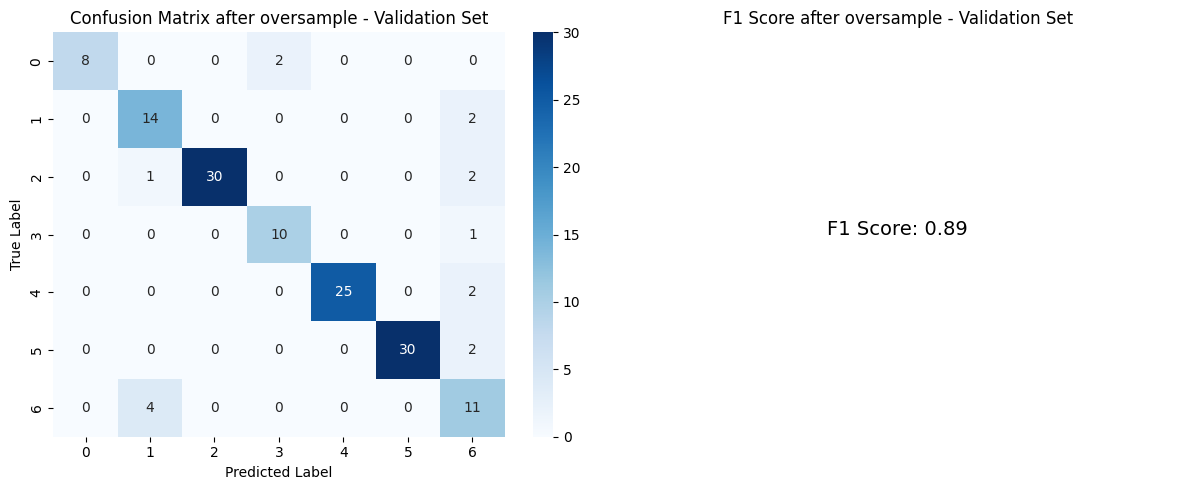

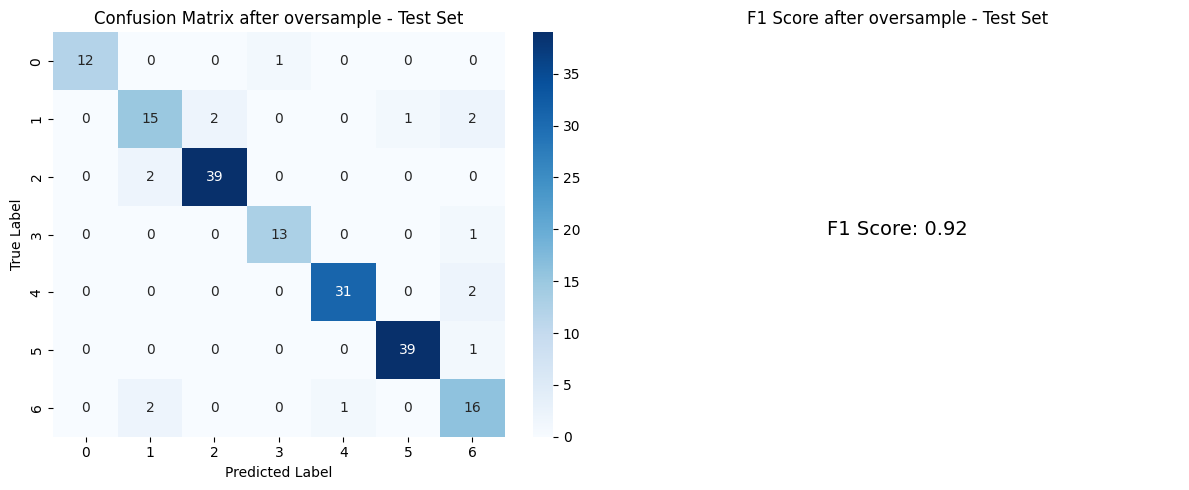

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

def modelling_SVC(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    model = SVC()
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE:
modelling_SVC(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True)


Cross Validation Scores: [0.92810458 0.90849673 0.91503268 0.88157895 0.92763158]
Average Cross Validation Score: 0.9121689026487788


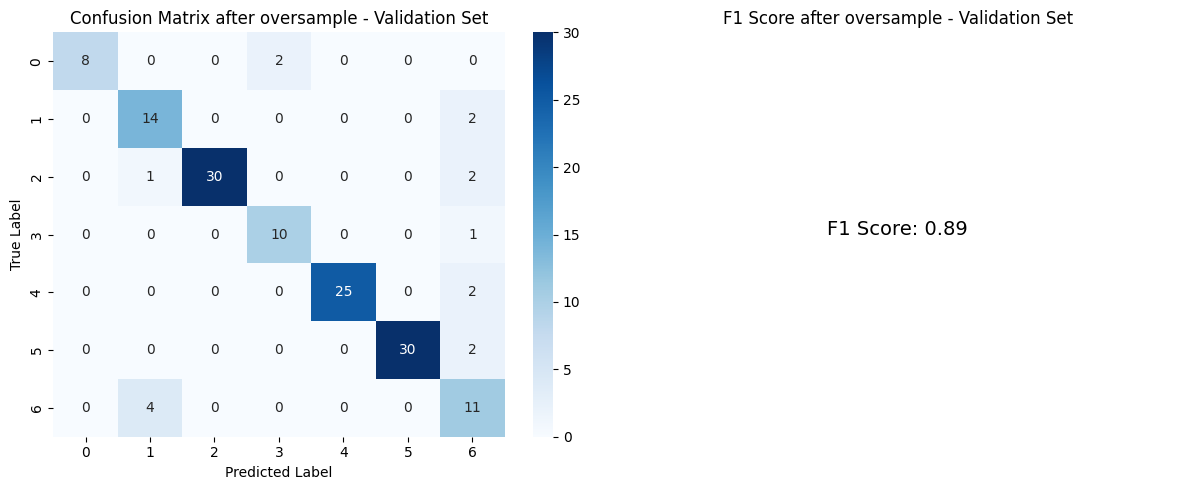

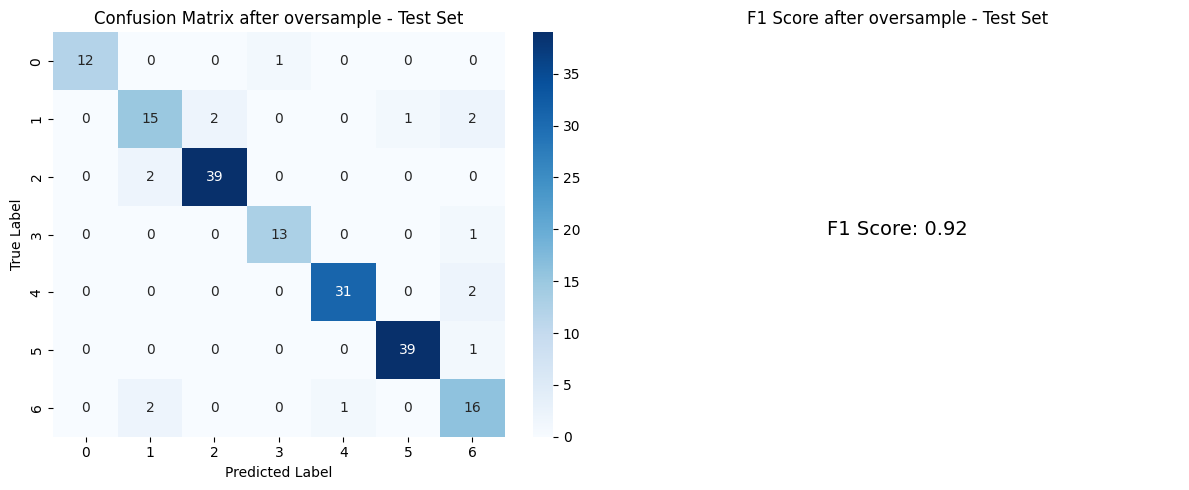

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def modelling_SVC_with_CV(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    model = SVC()

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    cv_scores = cross_val_score(model, x_train_resampled, y_train_resampled, cv=skf, scoring='f1_micro')

    print("Cross Validation Scores:", cv_scores)
    print("Average Cross Validation Score:", cv_scores.mean())  # Print the average cross-validation score

    # Fit the model on the full training data
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and cross-validation:
modelling_SVC_with_CV(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, oversample=True)


  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Tobi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


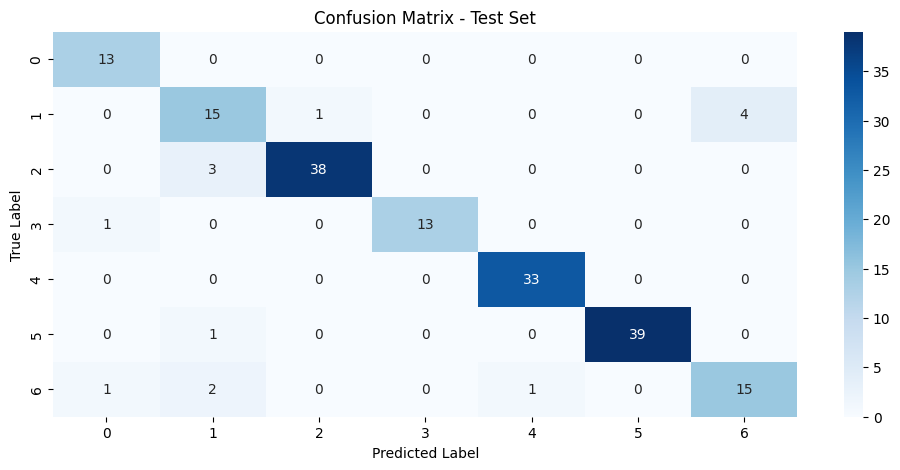

F1 Score for Test Set: 0.92
Best Parameters: {'kernel': 'linear', 'C': 14.0, 'gamma': 0.1}
Best F1 Score: 0.9166666666666666


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid

def modelling_SVC(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True,
                  kernels=['linear', 'rbf', 'poly'], 
                  Cs=[1.0, 5.0, 14.0], 
                  gammas=[0.1, 0.01, 0.001]):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}
    best_params = None
    best_f1_score = 0.0

    for kernel in kernels:
        for C in Cs:
            for gamma in gammas:
                if oversample:
                    # Perform oversampling on the training data using SMOTE
                    smote = SMOTE(random_state=0)
                    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
                else:
                    x_train_resampled, y_train_resampled = x_train, y_train

                model = SVC(kernel=kernel, C=C, gamma=gamma)
                model.fit(x_train_resampled, y_train_resampled)

                # Predict on the validation set
                y_pred_val = model.predict(x_val)

                # Calculate F1 score for validation set
                f1_score_val = f1_score(y_val, y_pred_val, average='micro')

                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}

    # Re-train the model with the best parameters on the entire training set
    best_model = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
    best_model.fit(x_train_resampled, y_train_resampled)

    # Predict on the test set using the best model
    y_pred_test = best_model.predict(x_test)

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for the test set
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')
        plt.show()

        print(f'F1 Score for {set_name} Set: {metrics["F1 Score"]:.2f}')

    return best_params, best_f1_score

# Example usage with SMOTE and parameter tuning:
best_params, best_f1_score = modelling_SVC(x_train_scaled, x_val_scaled, x_test_scaled, 
                                            y_train_encoded, y_val_encoded, y_test_encoded, 
                                            oversample=True,
                                            kernels=['linear', 'rbf', 'poly'], 
                                            Cs=[1.0, 5.0, 14.0], 
                                            gammas=[0.1, 0.01, 0.001])

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)


All Combinations and their F1 Scores for Test Set:
{'kernel': 'linear', 'C': 1.0, 'gamma': 0.1, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 1.0, 'gamma': 0.01, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 1.0, 'gamma': 0.001, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 5.0, 'gamma': 0.1, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 5.0, 'gamma': 0.01, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 5.0, 'gamma': 0.001, 'F1 Score': 0.9097222222222222}
{'kernel': 'linear', 'C': 14.0, 'gamma': 0.1, 'F1 Score': 0.9166666666666666}
{'kernel': 'linear', 'C': 14.0, 'gamma': 0.01, 'F1 Score': 0.9166666666666666}
{'kernel': 'linear', 'C': 14.0, 'gamma': 0.001, 'F1 Score': 0.9166666666666666}
{'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1, 'F1 Score': 0.8958333333333334}
{'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'F1 Score': 0.8888888888888888}
{'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001, 'F1 Score': 0.8263888888888888}
{'kernel': 'rbf', '

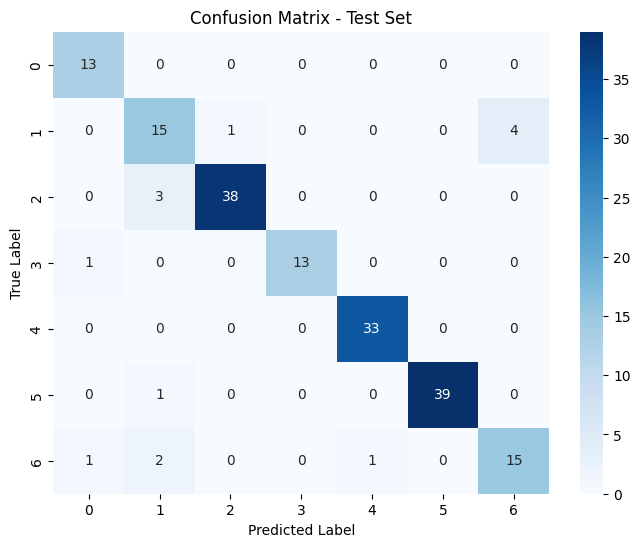

F1 Score for Test Set: 0.92
Best Parameters: {'kernel': 'linear', 'C': 14.0, 'gamma': 0.1}
Best F1 Score: 0.9166666666666666


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid

def modelling_SVC(x_train, x_val, x_test, y_train, y_val, y_test, oversample=True,
                  kernels=['linear', 'rbf', 'poly'], 
                  Cs=[1.0, 5.0, 14.0], 
                  gammas=[0.1, 0.01, 0.001]):
    # Create an empty list to store all the combinations and their F1 scores
    all_combinations = []

    best_params = None
    best_f1_score = 0.0

    for kernel in kernels:
        for C in Cs:
            for gamma in gammas:
                if oversample:
                    # Perform oversampling on the training data using SMOTE
                    smote = SMOTE(random_state=0)
                    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
                else:
                    x_train_resampled, y_train_resampled = x_train, y_train

                model = SVC(kernel=kernel, C=C, gamma=gamma)
                model.fit(x_train_resampled, y_train_resampled)

                # Predict on the validation set
                y_pred_val = model.predict(x_val)

                # Calculate F1 score for validation set
                f1_score_val = f1_score(y_val, y_pred_val, average='micro')

                # Save combination and F1 score
                all_combinations.append({'kernel': kernel, 'C': C, 'gamma': gamma, 'F1 Score': f1_score_val})

                if f1_score_val > best_f1_score:
                    best_f1_score = f1_score_val
                    best_params = {'kernel': kernel, 'C': C, 'gamma': gamma}

    # Print all combinations and their F1 scores
    print("All Combinations and their F1 Scores for Test Set:")
    for combination in all_combinations:
        print(combination)

    # Re-train the model with the best parameters on the entire training set
    best_model = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
    best_model.fit(x_train_resampled, y_train_resampled)

    # Predict on the test set using the best model
    y_pred_test = best_model.predict(x_test)

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_test, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # Display F1 score for the test set
    print(f'F1 Score for Test Set: {f1_score_test:.2f}')

    return best_params, best_f1_score

# Example usage with SMOTE and parameter tuning:
best_params, best_f1_score = modelling_SVC(x_train_scaled, x_val_scaled, x_test_scaled, 
                                            y_train_encoded, y_val_encoded, y_test_encoded, 
                                            oversample=True,
                                            kernels=['linear', 'rbf', 'poly'], 
                                            Cs=[1.0, 5.0, 14.0], 
                                            gammas=[0.1, 0.01, 0.001])

print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)


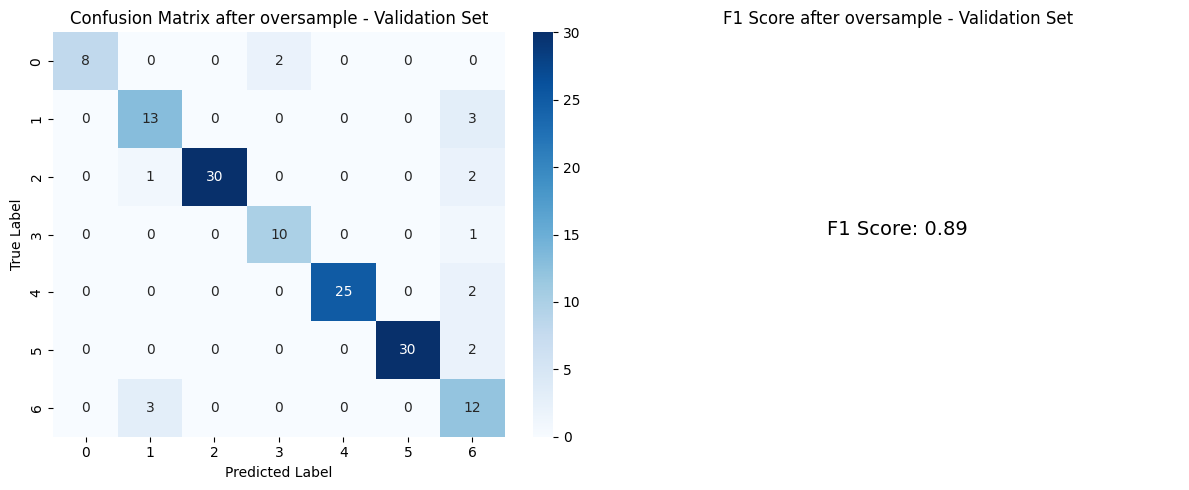

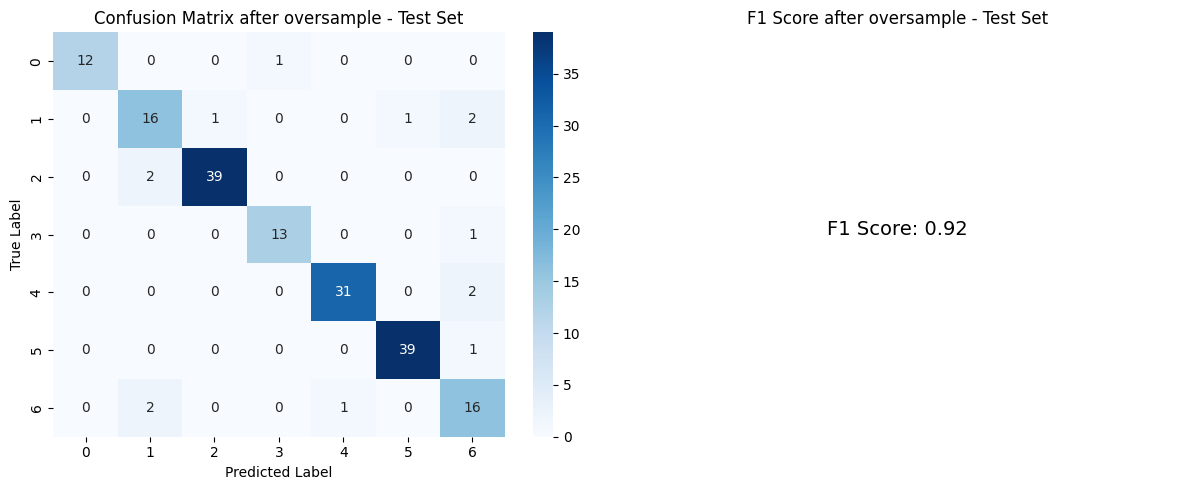

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

def modelling_weighted_SVC(x_train, x_val, x_test, y_train, y_val, y_test, class_weights=None, oversample=True):
    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    model = SVC(class_weight=class_weights)  # Set class weights
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix after oversample - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score after oversample - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and weighted SVM:
modelling_weighted_SVC(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, class_weights='balanced', oversample=False)


Class Weights:
{0: 16.2, 1: 9.0, 2: 4.458715596330276, 3: 14.294117647058824, 4: 4.811881188118812, 5: 4.811881188118812, 6: 8.526315789473685}


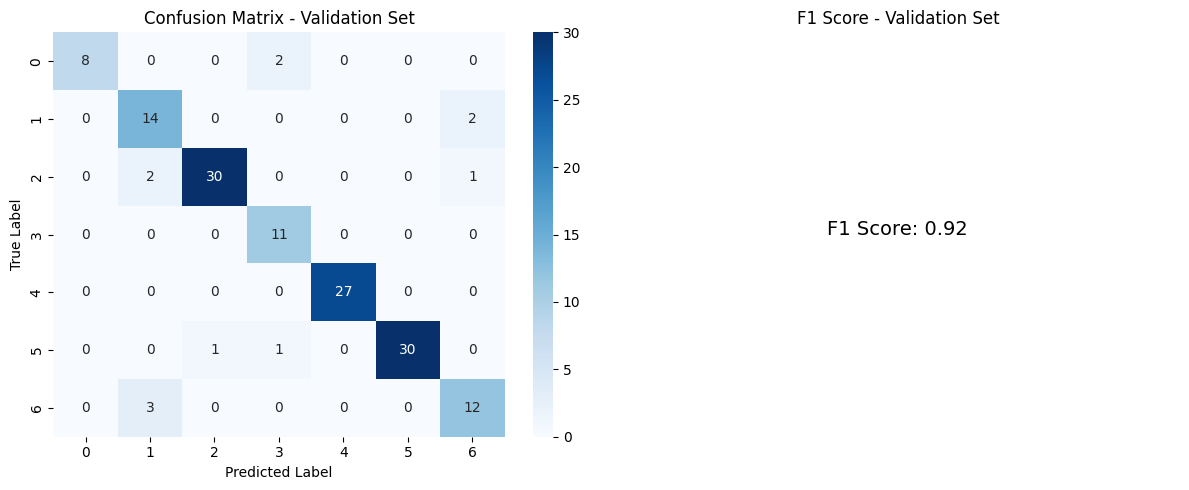

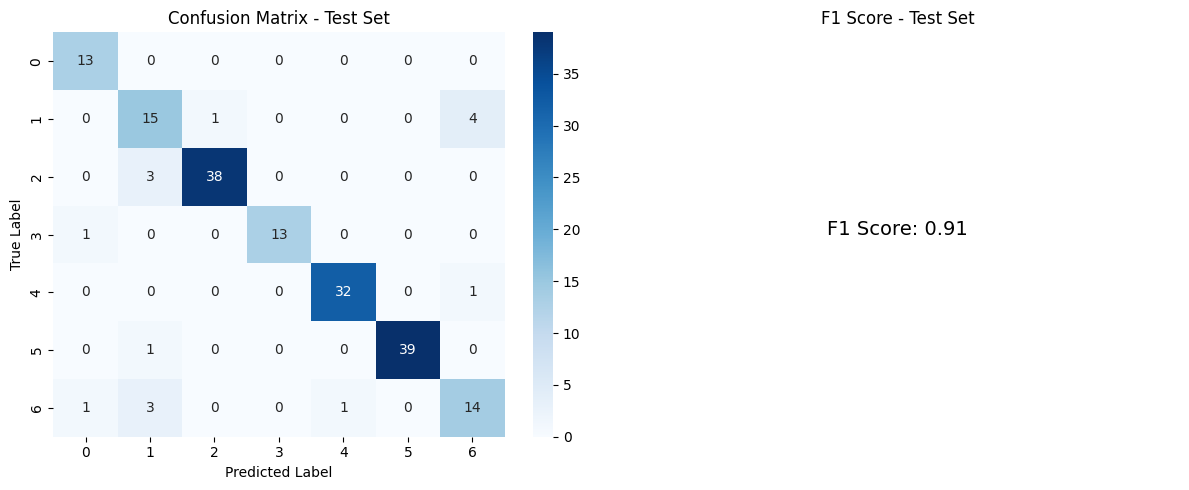

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import numpy as np

def weighted_SVM(x_train, x_val, x_test, y_train, y_val, y_test, class_weights=None, oversample=True):
    # Calculate class weights
    if class_weights is None:
        class_names = np.unique(y_train)
        class_frequencies = [np.sum(y_train == c) for c in class_names]
        total_samples = len(y_train)
        class_weights = {class_names[i]: total_samples / freq for i, freq in enumerate(class_frequencies)}
        print("Class Weights:")
        print(class_weights)

    # Create an empty dictionary to store the confusion matrices and F1 scores
    evaluation_results = {}

    if oversample:
        # Perform oversampling on the training data using SMOTE
        smote = SMOTE(random_state=0)
        x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
    else:
        x_train_resampled, y_train_resampled = x_train, y_train

    # Initialize weighted SVM model with specified parameters
    model = SVC(gamma='auto', class_weight=class_weights, kernel='linear', C=14)
    model.fit(x_train_resampled, y_train_resampled)

    # Predict on the validation set
    y_pred_val = model.predict(x_val)
    # Predict on the test set
    y_pred_test = model.predict(x_test)

    # Calculate confusion matrix and F1 score for validation set
    confusion_matrix_val = confusion_matrix(y_val, y_pred_val)
    f1_score_val = f1_score(y_val, y_pred_val, average='micro')
    evaluation_results['Validation'] = {'Confusion Matrix': confusion_matrix_val, 'F1 Score': f1_score_val}

    # Calculate confusion matrix and F1 score for test set
    confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
    f1_score_test = f1_score(y_test, y_pred_test, average='micro')
    evaluation_results['Test'] = {'Confusion Matrix': confusion_matrix_test, 'F1 Score': f1_score_test}

    # Plot the confusion matrix and display F1 score for both validation and test sets
    for set_name, metrics in evaluation_results.items():
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(metrics['Confusion Matrix'], annot=True, cmap='Blues', fmt='g')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {set_name} Set')

        # Display F1 score
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, f'F1 Score: {metrics["F1 Score"]:.2f}', fontsize=14, ha='center')
        plt.axis('off')
        plt.title(f'F1 Score - {set_name} Set')

        plt.tight_layout()
        plt.show()

# Example usage with SMOTE and weighted SVM:
weighted_SVM(x_train_scaled, x_val_scaled, x_test_scaled, y_train_encoded, y_val_encoded, y_test_encoded, class_weights=None, oversample=False)
